Comparing the algorithms

/workspaces/distributed-speculative-inference/docs/illustration.pdf


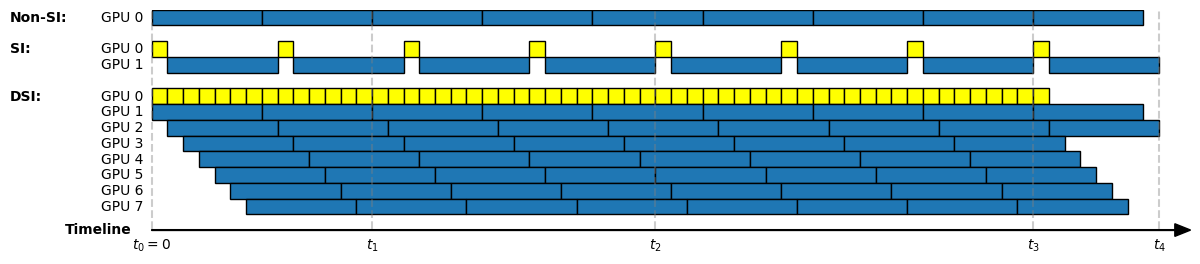

In [198]:
import os
from dataclasses import dataclass
from typing import List

import matplotlib.pyplot as plt


class Color:
    blue = "#1f77b4"
    yellow = "yellow"


@dataclass
class TimeUnit:
    width: int
    color: None | Color


@dataclass
class GPU:
    time_units: List[TimeUnit]


@dataclass
class Algorithm:
    name: str
    gpus: List[GPU]


def draw_time_unit(ax, time_unit: TimeUnit, x, y):
    """Draw a rectangle at position (x, y) based on the TimeUnit dataclass.
    If the color is None, the rectangle transparent with no border so that it fills the
    space but doesn't show."""
    if time_unit.color is None:
        ax.add_patch(
            plt.Rectangle(
                (x, y), time_unit.width, 1, edgecolor="none", facecolor="none"
            )
        )
    else:
        ax.add_patch(
            plt.Rectangle(
                (x, y), time_unit.width, 1, edgecolor="black", facecolor=time_unit.color
            )
        )


def draw_gpu(ax, gpu: GPU, y_offset, algorithm_name=None, gpu_label=None):
    """Draw a row of rectangles based on the GPU dataclass."""
    x_start = 0
    for time_unit in gpu.time_units:
        draw_time_unit(ax, time_unit, x_start, y_offset)
        x_start += time_unit.width
    if algorithm_name:
        ax.text(
            -9,
            y_offset + 0.5,
            algorithm_name,
            ha="left",
            va="center",
            fontsize=10,
            fontweight="bold",
        )
    if gpu_label:
        ax.text(-0.5, y_offset + 0.5, gpu_label, ha="right", va="center", fontsize=10)


def draw_algorithm(ax, algorithm: Algorithm, start_y):
    """Draw all GPUs of an algorithm with consistent spacing."""
    for i, gpu in enumerate(algorithm.gpus):
        algorithm_name = f"{algorithm.name}:" if i == 0 else ""
        gpu_label = f"GPU {i}"
        draw_gpu(ax, gpu, start_y - i, algorithm_name, gpu_label)
    return start_y - len(algorithm.gpus)


def setup_axes(ax):
    """Configure the plot axes for better visualization."""
    ax.set_xlim(-5, 66)
    ax.set_ylim(-14.5, 1)  # Adjust based on the number of rows and spacing required
    ax.set_aspect("equal")
    ax.axis("off")
    # Draw an arrow indicating the timeline
    ax.arrow(0, -13, 65, 0, head_width=0.8, head_length=1, fc="k", ec="k", width=0.05)
    # Left to arrow
    ax.text(
        -5.5,
        -13,
        "Timeline",
        ha="left",
        va="center",
        fontsize=10,
        fontweight="bold",
    )


def plot_timepoint(ax, x, label):
    """Draw a vertical dashed line at x and label it."""
    ax.axvline(x, color="gray", linestyle="--", alpha=0.4, ymin=0.1)
    ax.text(x, -14, label, ha="center", va="center", fontsize=10)


def plot_graph():
    target_latency = 7
    # Define the Alternatives and Rows (unchanged)
    alg_a = Algorithm(
        name="Non-SI",
        gpus=[GPU(time_units=[TimeUnit(width=target_latency, color=Color.blue)] * 9)],
    )

    alg_b = Algorithm(
        name="SI",
        gpus=[
            GPU(
                time_units=[
                    *(
                        [TimeUnit(width=1, color=Color.yellow)]
                        + [TimeUnit(width=target_latency, color=None)]
                    )
                ]
                * 8
            ),
            GPU(
                time_units=[
                    *(
                        [TimeUnit(width=1, color=None)]
                        + [TimeUnit(width=target_latency, color=Color.blue)]
                    )
                ]
                * 8
            ),
        ],
    )

    alg_c = Algorithm(
        name="DSI",
        gpus=[
            GPU(time_units=[TimeUnit(width=1, color=Color.yellow)] * 57),
            GPU(time_units=[TimeUnit(width=target_latency, color=Color.blue)] * 9),
            GPU(
                time_units=[TimeUnit(width=1, color=None)]
                + [TimeUnit(width=target_latency, color=Color.blue)] * 9
            ),
            GPU(
                time_units=[TimeUnit(width=1, color=None)] * 2
                + [TimeUnit(width=target_latency, color=Color.blue)] * 8
            ),
            GPU(
                time_units=[TimeUnit(width=1, color=None)] * 3
                + [TimeUnit(width=target_latency, color=Color.blue)] * 8
            ),
            GPU(
                time_units=[TimeUnit(width=1, color=None)] * 4
                + [TimeUnit(width=target_latency, color=Color.blue)] * 8
            ),
            GPU(
                time_units=[TimeUnit(width=1, color=None)] * 5
                + [TimeUnit(width=target_latency, color=Color.blue)] * 8
            ),
            GPU(
                time_units=[TimeUnit(width=1, color=None)] * 6
                + [TimeUnit(width=target_latency, color=Color.blue)] * 8
            ),
        ],
    )

    # Create figure and plot
    fig, ax = plt.subplots(figsize=(12, 10))
    setup_axes(ax)

    # Plotting each alternative using draw_algorithm
    start_y = 0
    start_y = draw_algorithm(ax, alg_a, start_y)
    start_y = draw_algorithm(ax, alg_b, start_y - 1)
    draw_algorithm(ax, alg_c, start_y - 1)

    # Plot timepoints
    non_si = 8 * target_latency
    si_worst = non_si + 1 + target_latency
    si_best = (1 + target_latency) * 4
    dsi_best = 2 * target_latency
    plot_timepoint(ax, 0, "$t_0=0$")
    plot_timepoint(ax, dsi_best, "$t_1$")
    plot_timepoint(ax, si_best, "$t_2$")
    plot_timepoint(ax, non_si, "$t_3$")
    plot_timepoint(ax, si_worst, "$t_4$")

    plt.tight_layout()
    # plt.show()
    # Save the figure to a file to use in the LaTeX paper
    filename = "illustration.pdf"
    # The directory of this notebook
    current_dirpath = os.getcwd()
    filepath = os.path.join(current_dirpath, filename)
    print(filepath)
    plt.savefig(filepath, bbox_inches="tight", pad_inches=0, transparent=True, dpi=300)


plot_graph()

In [209]:
import numpy as np
import pandas as pd


def create_dataframe(data, columns, scenarios):
    """
    Create a DataFrame from given data with a multilevel index directly from the
    scenarios.

    Args:
    data (np.array): Array containing the data.
    columns (list): List of column names.
    scenarios (list of tuples): List of tuples for the multilevel index.

    Returns:
    pd.DataFrame: DataFrame with multilevel index and data organized accordingly.
    """
    index_multi = pd.MultiIndex.from_tuples(scenarios, names=["Scenario", "Algorithm"])
    return pd.DataFrame(data, index=index_multi, columns=columns)


def display_dataframe(df):
    """
    Display the DataFrame.

    Args:
    df (pd.DataFrame): DataFrame to display.
    """
    print(df)


# Data reflecting each specific scenario
data = np.array(
    [
        [0, 2, 4, 8, 9],  # Worst case, non-SI
        [0, 1, 4, 8, 9],  # Worst case, SI
        [0, 2, 4, 8, 9],  # Worst case, DSI
        [0, 2, 4, 8, 9],  # Best case, non-SI
        [0, 2, 8, 14, 16],  # Best case, SI
        [0, 8, 26, 50, 58],  # Best case, DSI
    ]
)

columns = ["t0=0", "t1", "t2", "t3", "t4"]

scenarios = [
    ("worst case", "non-SI"),
    ("worst case", "SI"),
    ("worst case", "DSI"),
    ("best case", "non-SI"),
    ("best case", "SI"),
    ("best case", "DSI"),
]

df = create_dataframe(data, columns, scenarios)
display_dataframe(df)

                      t0=0  t1  t2  t3  t4
Scenario   Algorithm                      
worst case non-SI        0   2   4   8   9
           SI            0   1   4   8   9
           DSI           0   2   4   8   9
best case  non-SI        0   2   4   8   9
           SI            0   2   8  14  16
           DSI           0   8  26  50  58


In [219]:
df.index = [f"{scenario}: {algorithm}" for scenario, algorithm in df.index]
display_dataframe(df)

                    t0=0  t1  t2  t3  t4
worst case: non-SI     0   2   4   8   9
worst case: SI         0   1   4   8   9
worst case: DSI        0   2   4   8   9
best case: non-SI      0   2   4   8   9
best case: SI          0   2   8  14  16
best case: DSI         0   8  26  50  58


In [221]:
# Export to LaTeX
df.to_latex("benchmark.tex", index=True, float_format="{:.0f}".format)